In [2]:
#from tqdm import tqdm
from qiskit import quantum_info
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
import matplotlib.pyplot as plt
import numpy as np
import pickle
from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import Parameter
from qiskit_ibm_runtime import Estimator, Session, QiskitRuntimeService, Options, Sampler
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
#InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Save an IBM Quantum account.
QiskitRuntimeService.save_account(channel="ibm_quantum", token="253c04c1782fbe76188d45069e8bb89a54c779e469a1e55417ad64306275238b8f7d6030db8b71b4292b2239a70d14290b4781376aeef8c98f239d8078a5e291",overwrite=True)

In [4]:

def Shat(A,T,G): 
    
    t = np.tanh(T/4 + G/4)
    tt = np.tanh(T/4 - G/4)
    Shatf = np.array([[1-t*tt,0,0,t+tt],[0,1+t*tt,t-tt,0],[0,-t+tt,1+t*tt,0],[-t-tt,0,0,1-t*tt]],dtype=complex)
    Shatg = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]],dtype=complex)
    f = -(1j/4)*A*(2*np.cosh(T/2)+2*np.cosh(G/2))*(1/np.sinh(T/2))*(1/np.cosh(T/2))
    Shat = f*Shatf+Shatg
    Nalpha = 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)
    Shat = (1/np.sqrt(Nalpha))*Shat
    return Shat

def Nk(T):
    return (np.cosh(T/2))/2

def K(T):
    
    K2 = Ur = np.zeros((2,2), dtype=complex)
    
    coef1 = np.cos(np.pi/4 + 1j*T/2)
    coef2 = np.cos(np.pi/4 - 1j*T/2)
    
    K2[0,0]=coef1
    K2[1,1]=coef2
    K2 = 1/np.sqrt(np.cosh(T)/2)*K2
    
    return K2



def Ur(A,T,G):  #NUMERICALLY CHECKED, CORRECT#
    
    Ur = np.zeros((4,4), dtype=complex)
    
    coef1=np.sqrt(1+A**(2)*(4*np.cosh(G/2)**(2)*(1/np.sinh(T)**(2))+(1/np.cosh(T/2)**2)))
    
    coef2=np.sqrt(2*A**(2)*(np.cosh(G)+np.cosh(T))+np.sinh(T)**2)
    
    
    Ur[0,0]=(1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    Ur[0,3]=(2*A*np.sinh(T/2))/coef2
    
    Ur[1,1]=(2*A*np.cosh(T/2))/coef2
    
    Ur[1,2]=(1j + 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,1]=(1j - 2*A*(1/np.sinh(T))*np.sinh(G/2))/coef1
    
    Ur[2,2]=(2*A*np.cosh(T/2))/coef2
    
    Ur[3,0]=-(2*A*np.sinh(T/2))/coef2
    
    Ur[3,3]=(-1j+2*A*np.cosh(G/2)*(1/np.sinh(T)))/coef1
    
    return(Ur)


def bwassembler_z(qc,matrix,layers,n):    #CHECKED#
    
    m=0
    while m < layers:
        i=0;j=0;    
        #even layer
        while i < n/2:
            qc.unitary(matrix, [2*i,2*i+1])
            i+=1;
        qc.barrier(range(n)) 
        #odd layer
        while j < n/2:
            
            if j == (n/2 - 1):
                
                qc.unitary(perm4site(matrix),[0,1,2,3],label='ZZ')
                
            else:
                qc.unitary(matrix, [2*j+1,2*j+2])
            
            j+=1;
        qc.barrier(range(n))
        
        m+=1
    
    return(qc)


def perm4site(U):   #CHECKED#
    
    P = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,-1]])
    
    P12 = np.kron(P,np.eye(4))
    P23 = np.kron(np.eye(2),np.kron(P,np.eye(2)))
    P34 = np.kron(np.eye(4),P)
    S34 = np.kron(np.eye(4),U)
    
    return P12@P23@P34@S34@P34@P23@P12
       
    
def prodstaten(n):   #CHECKED#
    
    X = np.array([[0,1],[1,0]])
    X0 = np.zeros((n,2**n,2**n),dtype = complex)
    
    for i in range(0,n):   
        X0[i]=np.kron(np.kron(np.eye(2**i),X),np.eye(2**(n-i-1)))
    operator = np.eye(2**n)
    for i in range(0,n//2):
        operator = (X0[2*i]-1j*X0[2*i+1])@operator
    return (1/np.sqrt(2**(n//2)))*operator

def Na(A,T,G):
    return 1+2*A**(2)*(np.cosh(T)/np.sinh(T))*(1/np.sinh(T))+2*A**(2)*np.cosh(G)*(1/np.sinh(T))**(2)




dispcolors = {'cx':('#426299', '#000000'),
              'cswap':('#705399', '#000000'),
              'cp':('#CFFF8B', '#000000')}

basis_gates=['ecr', 'id', 'rz', 'sx', 'x']

In [5]:
%%time
#SWAP EE computation 4 sites old way

n,A,G,layers=4,1.2,20,1
thetas= np.arange(0.1,0.3,0.05)
renyi_loc = np.zeros((len(thetas)),dtype=complex)

for k,T in enumerate(thetas):    
    qa = QuantumRegister(4, name='qa')
    qb = QuantumRegister(4, name='qb')
    anc = QuantumRegister(1, name='ancilla')
    c = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qa, qb,anc,c)
    qc.h(8)
    qc.barrier(range(2*n+1))
    l=0
    
    while l<layers:
        #first half
        qc.unitary(Shat(A,T,G),[0,1],label='S12')
        qc.unitary(Shat(A,T,G),[2,3],label='S34')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,G),[1,2],label='S23')
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,0),[0,1],label='S12')
        qc.unitary(Shat(A,T,0),[2,3],label='S34')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,-G),[1,2],label='S23')
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,-G),[0,1],label='S12')
        qc.unitary(Shat(A,T,-G),[2,3],label='S34')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,-G),[1,2],label='S23')
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        
        qc.unitary(Shat(A,T,0),[0,1],label='S12')
        qc.unitary(Shat(A,T,0),[2,3],label='S34')
        qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
        qc.unitary(Shat(A,T,G),[1,2],label='S23')
        qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
        #second half
        qc.unitary(Shat(A,T,G),[4,5],label='S12B')
        qc.unitary(Shat(A,T,G),[6,7],label='S34B')
        qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
        qc.unitary(Shat(A,T,G),[5,6],label='S23B')
        qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
        
        qc.unitary(Shat(A,T,0),[4,5],label='S12B')
        qc.unitary(Shat(A,T,0),[6,7],label='S34B')
        qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
        qc.unitary(Shat(A,T,-G),[5,6],label='S23B')
        qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
        
        qc.unitary(Shat(A,T,-G),[4,5],label='S12B')
        qc.unitary(Shat(A,T,-G),[6,7],label='S34B')
        qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
        qc.unitary(Shat(A,T,-G),[5,6],label='S23B')
        qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
        
        qc.unitary(Shat(A,T,0),[4,5],label='S12B')
        qc.unitary(Shat(A,T,0),[6,7],label='S34B')
        qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
        qc.unitary(Shat(A,T,G),[5,6],label='S23B')
        qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
        qc.barrier(range(2*n+1))

        l+=1
    
    
    qc.cswap(8,0,4)
    qc.cswap(8,1,5)
    qc.barrier(range(2*n+1))
    qc.h(8)
    qc.measure(8,0)


    ######EXECUTION########
    #specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.backend("simulator_statevector")
    #backend = service.least_busy(operational=True, simulator=False, min_num_qubits=127)
    pm = generate_preset_pass_manager(backend=backend, optimization_level=3)
    circuit = pm.run(qc)
    
    
    with Session(service, backend=backend) as session:
        sampler = Sampler(session=session)
        job = sampler.run(circuit, shots=16000,resilience_level=1)
        result = job.result()
    renyi_loc[k]=-np.log(result.quasi_dists[0][0]-result.quasi_dists[0][1]) 
    print(k,T,renyi_loc[k])
#print(dict(qc.count_ops()))
with open('L=4_OBC_Renyi_statevector.pkl', 'wb') as file:
    
    # A new file will be created
    pickle.dump(renyi_loc, file)   

0 0.1 (0.03861089912765567+0j)
1 0.15000000000000002 (0.09348684309346393+0j)
2 0.20000000000000004 (0.15738507150392292+0j)
3 0.25000000000000006 (0.24430334914983592+0j)
CPU times: user 3.33 s, sys: 84.6 ms, total: 3.42 s
Wall time: 59.5 s


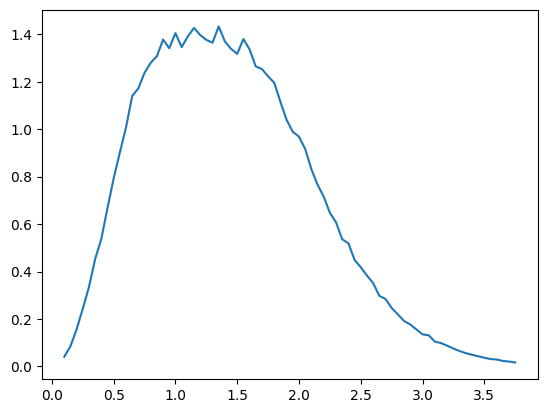

In [17]:
plt.plot(thetas,renyi_loc)


/home/alberto/.local/lib/python3.10/site-packages/matplotlib/cbook/__init__.py:1369: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


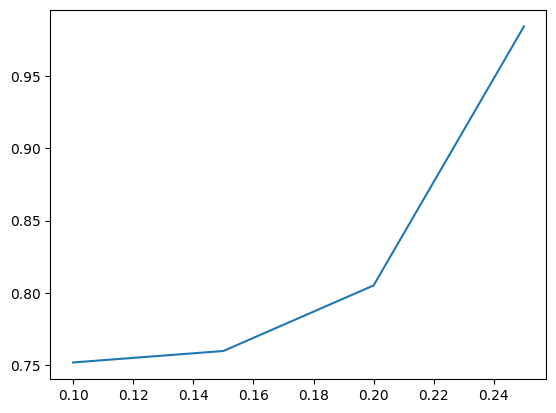

In [4]:
with open('L=4_OBC_Renyi_test_Matrix-free_Measurement_Mitigation.pkl', 'rb') as file:
    file = pickle.load(file)
thetas= np.arange(0.1,0.3,0.05)
plt.plot(thetas,file)

In [ ]:
#SWAP EE computation 4 sites global gate way

n,A,G,layers=4,1.2,20,1
thetas= np.arange(0.1,3.8,0.05)
renyi_loc = np.zeros((len(thetas)),dtype=complex)

for k,T in tqdm(enumerate(thetas)):    
    qa = QuantumRegister(4, name='qa')
    qb = QuantumRegister(4, name='qb')
    anc = QuantumRegister(1, name='ancilla')
    c = ClassicalRegister(1, name='c')
    qc = QuantumCircuit(qa, qb,anc,c)
    qc.h(8)
    qc.barrier(range(2*n+1))
    l=0
    layer1=np.kron(Shat(A,T,G),Shat(A,T,G))
    layer2=np.kron(np.kron(K(-T/2),Shat(A,T,G)),K(T/2))
    layer3=np.kron(Shat(A,T,0),Shat(A,T,0))
    layer4=np.kron(np.kron(K(-T/2),Shat(A,T,-G)),K(T/2))
    layer5=np.kron(Shat(A,T,-G),Shat(A,T,-G))
    layer6=np.kron(np.kron(K(-T/2),Shat(A,T,-G)),K(T/2))
    layer7=np.kron(Shat(A,T,0),Shat(A,T,0))
    layer8=np.kron(np.kron(K(-T/2),Shat(A,T,G)),K(T/2))
    matrix=layer8@layer7@layer6@layer5@layer4@layer3@layer2@layer1*(1/(Na(A,T,G)**(2)*(Na(A,T,0)**(2)*(Na(A,T,-G)**(2)*Nk(T)**(4)))))
    while l<layers:
        #first half
        qc.unitary(matrix,[0,1,2,3],label='UBW_A')
        #second half
        qc.unitary(matrix,[4,5,6,7],label='UBW_B')
        l+=1
    
    op = Operator(qc)
    op=op.data
    qc.cswap(8,0,4)
    qc.cswap(8,1,5)
    qc.barrier(range(2*n+1))
    qc.h(8)
    qc.measure(8,0)
    #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
    
    ######EXECUTION########
    #specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
    service = QiskitRuntimeService(channel="ibm_quantum")
    backend = service.backend("ibmq_qasm_simulator")
    
    with Session(service, backend=backend) as session:
        sampler = Sampler(session=session)
        job = sampler.run(qc, shots=8000)
        result = job.result()
    renyi[k]=-np.log(result.quasi_dists[0][0]-result.quasi_dists[0][1]) 
    print(k,T,renyi[k])

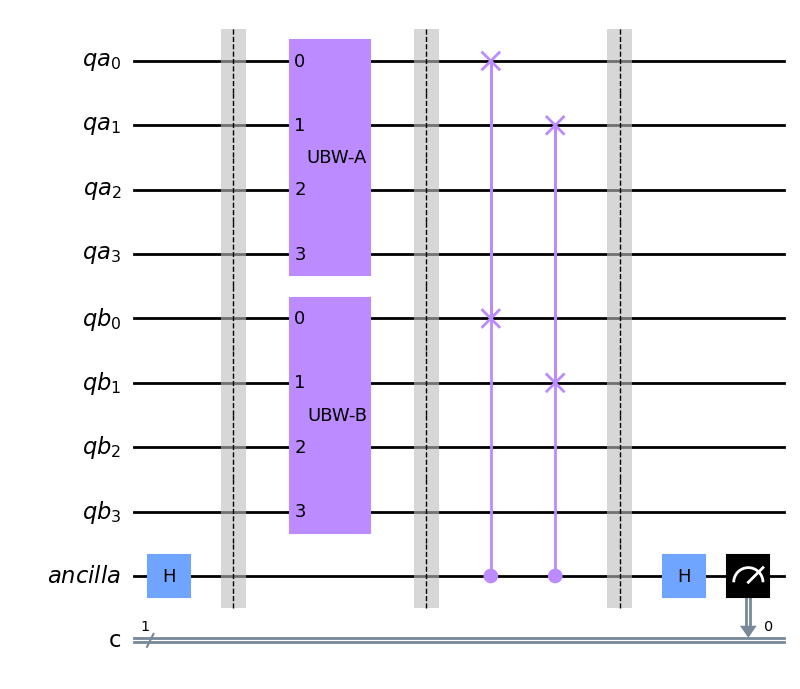

In [143]:
#verify if fermionic symmetry is true for the operator generating the 4 qubit evolution
A,T,G=1,1,1

qa = QuantumRegister(4, name='qa')
qb = QuantumRegister(4, name='qb')
anc = QuantumRegister(1, name='ancilla')
c = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qa, qb,anc,c)
qc.h(8)
qc.barrier(range(2*n+1))

layer1=np.kron(Shat(A,T,G),Shat(A,T,G))
layer2=np.kron(np.kron(K(-T/2),Shat(A,T,G)),K(T/2))

layer3=np.kron(Shat(A,T,0),Shat(A,T,0))
layer4=np.kron(np.kron(K(-T/2),Shat(A,T,-G)),K(T/2))

layer5=np.kron(Shat(A,T,-G),Shat(A,T,-G))
layer6=np.kron(np.kron(K(-T/2),Shat(A,T,-G)),K(T/2))

layer7=np.kron(Shat(A,T,0),Shat(A,T,0))
layer8=np.kron(np.kron(K(-T/2),Shat(A,T,G)),K(T/2))
matrix=layer8@layer7@layer6@layer5@layer4@layer3@layer2@layer1*(1/(Na(A,T,G)**(2)*(Na(A,T,0)**(2)*(Na(A,T,-G)**(2)*Nk(T)**(4)))))
qc.unitary(matrix,[0,1,2,3],label='UBW-A')
qc.unitary(matrix,[4,5,6,7],label='UBW-B')
qc.barrier(range(2*n+1))
qc.cswap(8,0,4)
qc.cswap(8,1,5)
qc.barrier(range(2*n+1))
qc.h(8)
qc.measure(8,0)
#qc = transpile(qc, basis_gates=basis_gates, optimization_level=2)
qc.draw(output='mpl', filename="/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC SWAP test.pdf")
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC SWAP test.pdf", bbox_inches='tight')  

In [129]:
x=np.exp(T/4);y=np.exp(G/4)
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
Q1plus=np.kron(X,np.eye(8))
Q2plus=np.kron(Z,np.kron(X,np.eye(4)))
Q3plus=np.kron(np.kron(Z,np.kron(Z,X)),np.eye(2))
Q4plus=np.kron(Z,np.kron(Z,np.kron(Z,X)))
Q1min=np.kron(Y,np.eye(8))
Q2min=np.kron(Z,np.kron(Y,np.eye(4)))
Q3min=np.kron(np.kron(Z,np.kron(Z,Y)),np.eye(2))
Q4min=np.kron(Z,np.kron(Z,np.kron(Z,Y)))
Qtotbefore1=Q1plus*(x*y)+Q2plus*(1/(x*y))+Q3plus*(x*y)+Q4plus*(1/(x*y)) + Q1min*(y/x)+Q2min*(x/y)+Q3min*(y/x)+Q4min*(x/y)

In [130]:
#verify fermionic symmetry for UBW defined locally
comm = Qtotbefore1@matrix-matrix@Qtotbefore1
print('fermionic symmetry is:',np.allclose(comm, 0*np.eye(16)))

fermionic symmetry is: True


In [137]:
n,A,T,G=4,1,1,1

qa = QuantumRegister(4, name='qa')
qb = QuantumRegister(4, name='qb')
anc = QuantumRegister(1, name='ancilla')
c = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qa, qb,anc,c)
qc.h(8)
qc.barrier(range(2*n+1))
l=0
while l<layers:
    #first half
    matrix=layer6@layer5@layer4@layer3@layer2@layer1*(1/(Na(A,T,G)*(Na(A,T,0)*(Na(A,T,-G)*Nk(T)**(3)))))
    qc = QuantumCircuit(n)
    qc.unitary(matrix,[0,1,2],label='UBW') 
    qc.barrier(range(2*n+1))
    l+=1
op=Operator(qc)
op=op.data
qc.cswap(8,0,4)
qc.cswap(8,1,5)
qc.barrier(range(2*n+1))
qc.h(8)


#qc = transpile(qc, basis_gates=basis_gates, optimization_level=2)
#qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

ExtensionError: 'Input matrix is not unitary.'

In [23]:
A,G,T=10.118,0,6.0
#layer by layer unitarity check 
layer1 = np.kron(Shat(A,T,G),K(T/2))
#layer1tilde=np.kron(Had,K(T/2))
layer2 = np.kron(K(-T/2),Shat(A,T,0))
#layer2tilde = np.kron(K(-T/2),Had)
layer3 = np.kron(Shat(A,T,-G),K(T/2))
print(np.allclose(layer1@layer1.conj().T,np.eye(8)),np.allclose(layer2@layer2.conj().T,np.eye(8)),np.allclose(layer3@layer3.conj().T,np.eye(8)))
layer4 = np.kron(K(-T/2),Shat(A,T,-G))
layer5 = np.kron(Shat(A,T,0),K(T/2))
layer6 = np.kron(K(-T/2),Shat(A,T,G))
print(np.allclose(layer4@layer4.conj().T,np.eye(8)),np.allclose(layer5@layer5.conj().T,np.eye(8)),np.allclose(layer6@layer6.conj().T,np.eye(8)))

False False False
False False False


In [121]:
x=np.exp(T/4);y=np.exp(G/4)
X=np.array([[0,1],[1,0]])
Y=np.array([[0,-1j],[1j,0]])
Z=np.array([[1,0],[0,-1]])
Q1plus=np.kron(X,np.eye(8))
Q2plus=np.kron(Z,np.kron(X,np.eye(4)))
Q3plus=np.kron(np.kron(Z,np.kron(Z,X)),np.eye(2))
Q4plus=np.kron(Z,np.kron(Z,np.kron(Z,X)))
Q1min=np.kron(Y,np.eye(8))
Q2min=np.kron(Z,np.kron(Y,np.eye(4)))
Q3min=np.kron(np.kron(Z,np.kron(Z,Y)),np.eye(2))
Q4min=np.kron(Z,np.kron(Z,np.kron(Z,Y)))
Qtotbefore1=Q1plus*(x*y)+Q2plus*(1/(x*y))+Q3plus*(x*y)+Q4plus*(1/(x*y)) + Q1min*(y/x)+Q2min*(x/y)+Q3min*(y/x)+Q4min*(x/y)

In [123]:
#verify fermionic symmetry for UBW or 3 sites - FERMIONIC SYMMETRY NOT SATISFIED
comm = Qtotbefore1@operator-operator@Qtotbefore1
print('fermionic symmetry is:',np.allclose(comm, 0*np.eye(16)))

fermionic symmetry is: False


We decide to implement the noise model as follows:
    -decide threshold probability p_th
    -every time we apply a unitary we do:
        -generate random number p between 0 and 1
            -if p>pth:
                continue (just apply unitary)
            -else:
                apply unitary, then choose random qubit line between the two and apply bit flip X
        -quench system (from |000....\rangle)
        -compute EE/RE for different sizes of partition for given p_th
        -tune p_th and repeat protocol 

We expect ad different entanglement scaling when considering bigger partitions as f(p_th) because we are explicitly breaking integrability

We are also breaking GFS 

In [21]:
#OBC BIPARTITION 4 sites, varying layers per datapoint


#Circuit parameters
n=4;A=1.2;G=20;

#Define arrays
 
thetas= np.arange(0.1,3.8,0.05)
layers = [1]
ent_entropy4 = np.zeros((len(layers),len(thetas)),dtype=complex)
renyi4 = np.zeros((len(layers),len(thetas)),dtype=complex)
eigvalsrho4 = np.zeros((len(layers),len(thetas),(2**(n//2))),dtype=complex)
subsystem = [0,1]
p_th=0.5
basis_gates=['cx', 'id', 'rz', 'x', 'sx']

for m,layer in enumerate(layers):
    print(layer)
    
    for k,T in tqdm(enumerate(thetas)):    
        
        
        string = "0" * (n)
        qc = QuantumCircuit(n)
        QuantumCircuit.initialize(qc,string)
        #init with Kareljan's state
        #qc.unitary(prodstaten(n), range(0,n))
        qc.barrier(range(n))
        l=0
        while l<layer:
            ##########
            qc.unitary(Shat(A,T,G),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)
                
            qc.unitary(Shat(A,T,G),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
                
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)
                
            qc.unitary(Shat(A,T,G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)
                
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)

            ##########
            qc.unitary(Shat(A,T,0),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)

            
            qc.unitary(Shat(A,T,0),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
            
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)



            qc.unitary(Shat(A,T,-G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)


            
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)

            ################
            qc.unitary(Shat(A,T,-G),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)


            
            qc.unitary(Shat(A,T,-G),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)
                
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)

            
            qc.unitary(Shat(A,T,-G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)

            
            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)

            ################
            qc.unitary(Shat(A,T,0),[0,1],label='S12')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([0, 1])
                qc.x(flip)

            
            qc.unitary(Shat(A,T,0),[2,3],label='S34')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([2, 3])
                qc.x(flip)


            
            qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(0)
                
            qc.unitary(Shat(A,T,G),[1,2],label='S23')
            k=np.random.rand(1)
            if k<p_th:
                flip = random.choice([1, 2])
                qc.x(flip)

            qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
            k=np.random.rand(1)
            if k<p_th:
                qc.x(3)

            
            qc.barrier(range(4))
            l+=1
        #qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)
        
        
        #######################################################################    
        #access density matrix  
        rho = DensityMatrix(qc)
        
        reduced_rho=partial_trace(rho, subsystem)
        
        #find the eigenvalues of the reduced density matrix
        eigenvalues,_ = np.linalg.eig(reduced_rho)
       
        #compute the entanglement entropy
        
        order = eigenvalues.argsort()
        eigenvalues = eigenvalues[order]
        eigvalsrho4[m,k,:]= eigenvalues
        entanglement_entropy = -np.sum(eigenvalues * np.log(eigenvalues))
        renyi4[m,k]=-np.log(DensityMatrix.purity(reduced_rho))
        ent_entropy4[m,k]=entanglement_entropy
        #print(k,ent_entropy[k])
        ######################################################################
            

1


74it [00:03, 22.38it/s]


In [8]:
k=np.random.rand(1)
if k<0.5:
    print('yes',k)
else:
    print('no',k)

yes [0.17594718]


In [7]:
csfont = {'fontname':'Serif'}
#plt.title('OBC EE N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0'+' shots=16000',**csfont)
thetas= np.arange(0.1,3.8,0.05)
plt.plot(thetas,renyi_loc,'x',c='lime',label='SWAP test')
plt.plot(thetas,renyi4[0],'-',c='m',label='ED')
#plt.plot(thetas,eigvalsrho4[0],'-.')
plt.xlabel(r'$\theta$', **csfont)
plt.ylabel('RE', **csfont)
plt.axhline(y=2*np.log(2), linestyle='--')
plt.xlim(-0.2,3.8)
plt.legend(loc='upper right')
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')
    
plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC SWAP TEST 4 site A=1.2 G=20 sim vs ED.pdf", bbox_inches='tight')  

NameError: name 'renyi_loc' is not defined

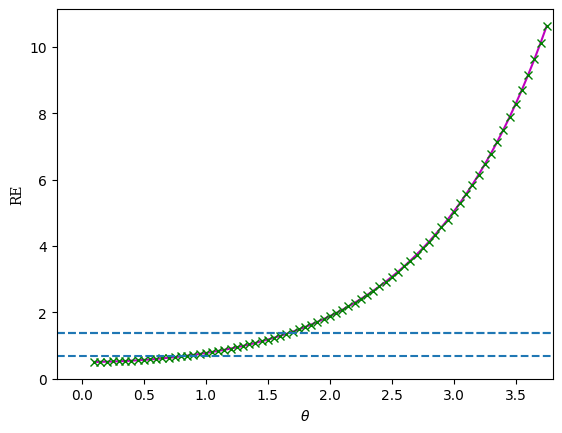

In [109]:
csfont = {'fontname':'Serif'}
#plt.title('OBC EE N='+str(n)+', A= '+str(A)+' G='+str(G)+' init 0'+' shots=16000',**csfont)
thetas= np.arange(0.1,3.8,0.05)
plt.plot(thetas,np.cosh(thetas)/2,c='m',label='Renyi')
plt.plot(thetas,np.cosh(thetas/2)**(2)-0.5,'x',c='g',label='Renyi')
plt.xlabel(r'$\theta$', **csfont)
plt.ylabel('RE', **csfont)
plt.axhline(y=2*np.log(2), linestyle='--')
plt.xlim(-0.2,3.8)
#plt.legend()
for j in range(1,3):
    plt.axhline(y=j*np.log(2), linestyle='--')
    
#plt.savefig("/mnt/c/Users/azorzat/OneDrive - UvA/Desktop/Plots Paper/OBC SWAP TEST 4 site A=1.2 G=20.pdf", bbox_inches='tight')  

In [ ]:
#from itertools import cycle
#colormap1 = plt.cm.cool
#color_cycle1 = cycle(colormap1(np.linspace(0, 1, len(layers))))
#colormap2 = plt.cm.spring
#color_cycle2 = cycle(colormap2(np.linspace(0, 1, len(layers))))
#leng= np.array([2,3,4],dtype=int)


#color1 = next(color_cycle1)
#plt.plot(thetas,ent_entropy[j]+j*np.log(2),'-.', c=color1,label='EE layers='+str(layer))
#color2 = next(color_cycle2)
plt.plot(thetas,renyi,'-.', c='m',label='RE A')

    
#plt.plot(thetas,eigvalsrho[0,:],'-,')


#plt.title('OBC EE N='+str(n)+', A= '+str(A)+' G='+str(G)+' init ps')
for j in range(1,5):
    plt.axhline(y=j*np.log(2), linestyle='--')

plt.xlabel(r'$\theta$')
#plt.xlim(-0.2,200)
plt.ylim(-0.1,3)
plt.legend()   


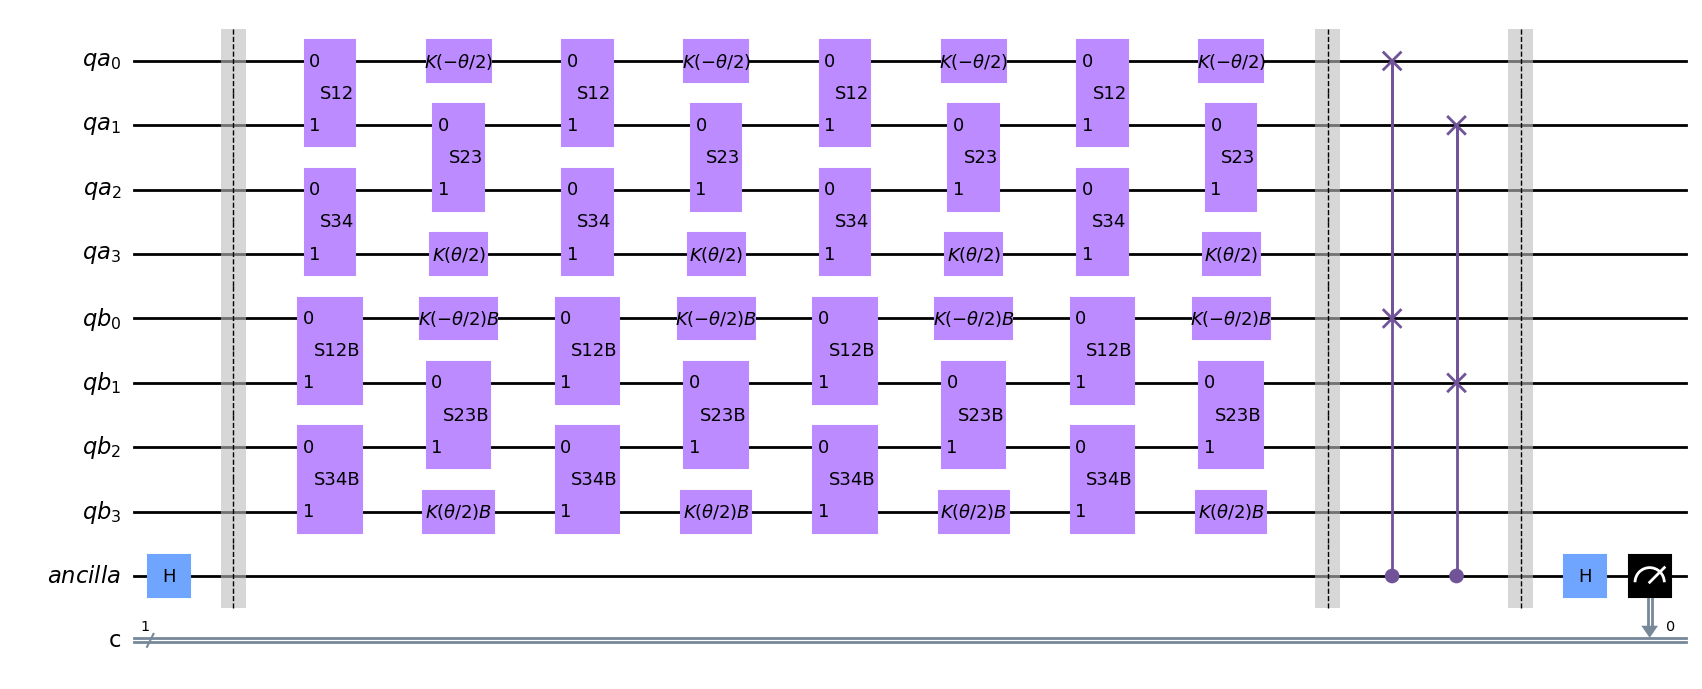

In [116]:
#debug, per theta 
A=1.2
G=20
T=0.1
layers=1
qa = QuantumRegister(4, name='qa')
qb = QuantumRegister(4, name='qb')
anc = QuantumRegister(1, name='ancilla')
c = ClassicalRegister(1, name='c')
qc = QuantumCircuit(qa, qb,anc,c)
qc.h(8)
qc.barrier(range(2*n+1))
l=0
while l<layers:
    #first half
    qc.unitary(Shat(A,T,G),[0,1],label='S12')
    qc.unitary(Shat(A,T,G),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12')
    qc.unitary(Shat(A,T,0),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,-G),[0,1],label='S12')
    qc.unitary(Shat(A,T,-G),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,-G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    qc.unitary(Shat(A,T,0),[0,1],label='S12')
    qc.unitary(Shat(A,T,0),[2,3],label='S34')
    qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
    qc.unitary(Shat(A,T,G),[1,2],label='S23')
    qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
    
    #second half
    qc.unitary(Shat(A,T,G),[4,5],label='S12B')
    qc.unitary(Shat(A,T,G),[6,7],label='S34B')
    qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
    qc.unitary(Shat(A,T,G),[5,6],label='S23B')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
    
    qc.unitary(Shat(A,T,0),[4,5],label='S12B')
    qc.unitary(Shat(A,T,0),[6,7],label='S34B')
    qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
    qc.unitary(Shat(A,T,-G),[5,6],label='S23B')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
    
    qc.unitary(Shat(A,T,-G),[4,5],label='S12B')
    qc.unitary(Shat(A,T,-G),[6,7],label='S34B')
    qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
    qc.unitary(Shat(A,T,-G),[5,6],label='S23B')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
    
    qc.unitary(Shat(A,T,0),[4,5],label='S12B')
    qc.unitary(Shat(A,T,0),[6,7],label='S34B')
    qc.unitary(K(-T/2),[4],label=r'$K(-\theta/2)B$')
    qc.unitary(Shat(A,T,G),[5,6],label='S23B')
    qc.unitary(K(T/2),[7],label=r'$K(\theta/2)B$')
    qc.barrier(range(2*n+1))
    l+=1

#oper = Operator(qa)
#oper=oper.data
#raise KeyboardInterrupt
qc.cswap(8,0,4)
qc.cswap(8,1,5)
qc.barrier(range(2*n+1))
qc.h(8)
qc.measure(8,0)
#qc = transpile(qc, basis_gates=basis_gates, optimization_level=1)

#######EXECUTION########
##specify the credentials when initializing QiskitRuntimeService, if they are not previously saved
#service = QiskitRuntimeService(channel="ibm_quantum")
#backend = service.backend("ibmq_qasm_simulator")
#
#with Session(service, backend=backend) as session:
#    sampler = Sampler(session=session)
#    job = sampler.run(qc, shots=600)
#    result = job.result()
#renyi=-np.log(result.quasi_dists[0][0]-result.quasi_dists[0][1]) 
qc.draw(output='mpl',style={'displaycolor':dispcolors}, filename='my_circuit.pdf')

In [118]:
qc = QuantumCircuit(4)
qc.unitary(Shat(A,T,G),[0,1],label='S12')
qc.unitary(Shat(A,T,G),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
qc.unitary(Shat(A,T,0),[0,1],label='S12')
qc.unitary(Shat(A,T,0),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,-G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
qc.unitary(Shat(A,T,-G),[0,1],label='S12')
qc.unitary(Shat(A,T,-G),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,-G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
qc.unitary(Shat(A,T,0),[0,1],label='S12')
qc.unitary(Shat(A,T,0),[2,3],label='S34')
qc.unitary(K(-T/2),[0],label=r'$K(-\theta/2)$')
qc.unitary(Shat(A,T,G),[1,2],label='S23')
qc.unitary(K(T/2),[3],label=r'$K(\theta/2)$')
operator=Operator(qc)
operator=operator.data